# Ore Proximity Model

A consultant is using metal abundance changes to predict proximity to an orebody.  Samples are classified as proximal (A) or distal (B) based on Euclidean distance to a wireframe model of the orebody.

1. Can we use the same geochemical data and labels to generate a predictive model for future drill holes which can label samples on whether they are in class A or class B?
2. More data has been acquired since the geochemist completed her work - can we predict labels onto these data points (labelled “?”).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import seaborn as sns
from scipy.stats import randint

## Step 1: Data - QA/QC

In [4]:
data = pd.read_csv('data/data_for_distribution.csv')
data.head()

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class
0,A04812,SOLVE003,561,571.0,NaN,0.066,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,A
1,A03356,SOLVE003,571,581.0,NaN,0.152,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,A
2,A04764,SOLVE003,581,591.0,NaN,0.068,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,A
3,A04626,SOLVE003,591,601.0,NaN,0.074,891.60,48620.0,63.0000,4.200,820.8000,39.6000,A
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,A


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  4771 non-null   object 
 1   holeid     4771 non-null   object 
 2   from       4771 non-null   int64  
 3   to         4771 non-null   float64
 4   As         3268 non-null   float64
 5   Au         4765 non-null   object 
 6   Pb         4756 non-null   float64
 7   Fe         4709 non-null   float64
 8   Mo         4741 non-null   float64
 9   Cu         4746 non-null   float64
 10  S          4761 non-null   float64
 11  Zn         4762 non-null   float64
 12  Class      4771 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 484.7+ KB


In [6]:
# Check how many NaN values are in each column
nan_values = data.isna().sum()

# Print the number of NaN values per column
print("Number of NaN values per column:")
print(nan_values)

Number of NaN values per column:
Unique_ID       0
holeid          0
from            0
to              0
As           1503
Au              6
Pb             15
Fe             62
Mo             30
Cu             25
S              10
Zn              9
Class           0
dtype: int64


Looking at the data, I saw that there are some there are some QA/QC issues.
These included
- Au data type is object
- missing values
- values below the detection limit (<0.005)
- unsuitable values (-999)

In [7]:
elements = ['As', 'Au', 'Pb', 'Fe', 'Mo', 'Cu', 'S', 'Zn']

# Replace '<0.005' with half of the detection limit and '-999' with NaN
data[elements] = data[elements].replace({'<0.005': 0.005 / 2, '-999': np.nan})

# Convert the 'Au' column to float64
data['Au'] = pd.to_numeric(data['Au'], errors='coerce')

# Drop NaN values
data_cleaned = data.dropna(subset=elements)

data_cleaned.to_csv("./data/cleaned_data.csv", index=False)
data_cleaned.head()


,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class
257,A03720,SOLVE026,731,741.0,5.0,0.122,1881.2,35440.0,133.0,6.0,2770.0,43.4,A
1043,A02183,SOLVE047,351,361.0,18.4,0.290,2150.0,65700.0,32.6,146.4,9854.0,362.0,A
1057,A04574,SOLVE052,411,421.0,6.6,0.076,1636.0,57380.0,57.4,12.2,1808.0,37.8,A
1058,A04149,SOLVE052,421,431.0,15.8,0.097,2375.6,53980.0,50.4,13.2,2878.0,35.6,A
1059,A05461,SOLVE052,431,441.0,18.6,0.046,1514.6,54920.0,18.6,13.8,2394.0,30.4,A


In [8]:
# Some checks:

# Check the data type of 'Au' column
print(data['Au'].dtype)

nan_check = data_cleaned.isna().sum()

# Print NaN values if any exist
if nan_check.any():
    print("NaN values in cleaned data:")
    print(nan_check[nan_check > 0], "\n")

for element in elements:
    # Check for values equal to '-999'
    if (data_cleaned[element] == -999).any():
        print(f"Warning: '{element}' contains '-999' values.")
    
    # Check for values equal to '<0.005'
    if (data_cleaned[element] == '<0.005').any():
        print(f"Warning: '{element}' contains '<0.005' values.")

float64


We can do other data checks but I am assuming these are the only issues and moving on

## Step 2: Modelling
### Aim 1: Generate a predictive model

In [9]:
# Check the distribution of classes
class_counts = data_cleaned['Class'].value_counts()
print(class_counts)

Class
A    1759
B     743
?     685
Name: count, dtype: int64


In [10]:
# Mostly from https://www.datacamp.com/tutorial/random-forests-classifier-python

# Separate labeled and unlabeled data
labeled_data = data_cleaned[data_cleaned['Class'].isin(['A', 'B'])]
unlabeled_data = data_cleaned[data_cleaned['Class'] == '?']

# Features and target
X = labeled_data[elements]
y = labeled_data['Class']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


#Hyperparameter tuning 
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 17, 'n_estimators': 466}


In [11]:
# Evaluate model
y_pred = best_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       363
           1       0.80      0.80      0.80       138

    accuracy                           0.89       501
   macro avg       0.86      0.86      0.86       501
weighted avg       0.89      0.89      0.89       501



Confusion Matrix:


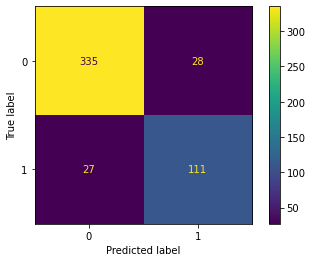

In [12]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [13]:
# #optional extra
# # Checking to see how the data was scaled

# # Visualize histograms before scaling for 'Fe' (example)
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(X['Fe'], bins=50, color='blue', alpha=0.7)
# plt.title('Before Scaling: Fe')

# # Visualize histograms after scaling for 'Fe'
# plt.subplot(1, 2, 2)
# plt.hist(X_scaled[:, X.columns.get_loc('Fe')], bins=50, color='green', alpha=0.7)
# plt.title('After Scaling: Fe')


In [14]:
# #optional extra
# Feature Importance
# feature_importances = best_rf.feature_importances_
# feature_importance_df = pd.DataFrame({'Element': elements, 'Importance': feature_importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Element', data=feature_importance_df, color='steelblue')
# plt.title('Feature Importance for Predicting Class A vs Class B')
# plt.tight_layout()
# plt.show()

### Aim 2: Predict labels 

In [17]:
unlabeled_data_copy = unlabeled_data.copy()

# Predict unlabeled data 
X_new = unlabeled_data[elements]
X_new_scaled = scaler.transform(X_new)
unlabeled_data.loc[:, 'Predicted_Class'] = le.inverse_transform(best_rf.predict(X_new_scaled))

print("Predictions on Unlabeled Data:")
print(unlabeled_data[['Unique_ID', 'holeid', 'Predicted_Class']].head(70))
unlabeled_data.to_csv('./data/predictions_on_unlabeled_data.csv', index=False)


Predictions on Unlabeled Data:
     Unique_ID      holeid Predicted_Class
4004    A04920  SOLVE225W1               A
4005    A05729  SOLVE225W1               A
4006    A05270  SOLVE225W1               A
4007    A05634  SOLVE225W1               A
4008    A04689  SOLVE225W1               A
...        ...         ...             ...
4072    A06469    SOLVE227               B
4073    A06256    SOLVE227               B
4074    A05766    SOLVE227               B
4075    A08273    SOLVE227               B
4076    A06155    SOLVE227               B

[70 rows x 3 columns]


Results available on: predictions_on_unlabeled_data.csv

In [18]:
# Filter the rows where the original 'Class' column is '?'
unlabeled_data_question = unlabeled_data[unlabeled_data['Class'] == '?']

# Count how many were predicted to be 'A' and 'B'
class_counts_from_question = unlabeled_data_question['Predicted_Class'].value_counts()

# Print out the prediction counts for 'A' and 'B' from '?'
print(f"Predictions for '?' class:")
print(class_counts_from_question)

Predictions for '?' class:
Predicted_Class
B    390
A    295
Name: count, dtype: int64


### Observations

- The model performs well overall, with high accuracy and strong performance for Class A.
- Class B predictions are less accurate.
- The imbalance in the dataset (more Class A samples) is probably why the model performs better for Class A 
- Pb has the highest feature importance (makes sense as this is a lead deposit)

### Improvements: 
- Handle missing values more effectively (instead of dropping).
- Perform additional model validation (e.g., cross-validation, ROC curves).
- Experiment with other models (e.g., SVM, Gradient Boosting) for comparison.